In [7]:
# LSTM + Dense 모델을 작성해 주가 예측
# 삼성전자 증권표준코드 : 005930
!pip install finance-datareader

            Open  High   Low  Close  Volume    Change
Date                                                 
1999-08-20  3560  3560  3460   3520  529333       NaN
1999-08-23  3590  3740  3560   3700  674482  0.051136
1999-08-24  3800  3879  3730   3850  794226  0.040541
             Open   High    Low  Close    Volume    Change
Date                                                      
2023-12-05  72300  72400  71200  71200  12129682 -0.019284
2023-12-06  71800  72100  71600  71700   8123087  0.007022
2023-12-07  71800  71900  71100  71500   7205205 -0.002789
DatetimeIndex(['1999-08-20', '1999-08-23', '1999-08-24', '1999-08-25',
               '1999-08-26', '1999-08-27', '1999-08-30', '1999-08-31',
               '1999-09-01', '1999-09-02',
               ...
               '2023-11-24', '2023-11-27', '2023-11-28', '2023-11-29',
               '2023-11-30', '2023-12-01', '2023-12-04', '2023-12-05',
               '2023-12-06', '2023-12-07'],
              dtype='datetime64[ns]', name='D

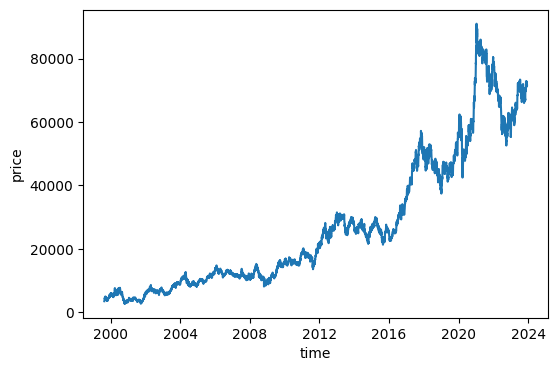

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import warnings
warnings.filterwarnings('ignore')

STOCK_CODE = '005930'
stock = fdr.DataReader(STOCK_CODE)
print(stock.head(3))
print(stock.tail(3))

# Data열을 이용해 연도별 주가 변동 시각화
# Data열을 연,월,일로 분리해 새로운 열을 추가
print(stock.index)
stock['year'] = stock.index.year
stock['month'] = stock.index.month
stock['day'] = stock.index.day
print(stock.head(3))
print(stock.shape)  # (6000, 9)

plt.figure(figsize=(6,4))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')
plt.show()

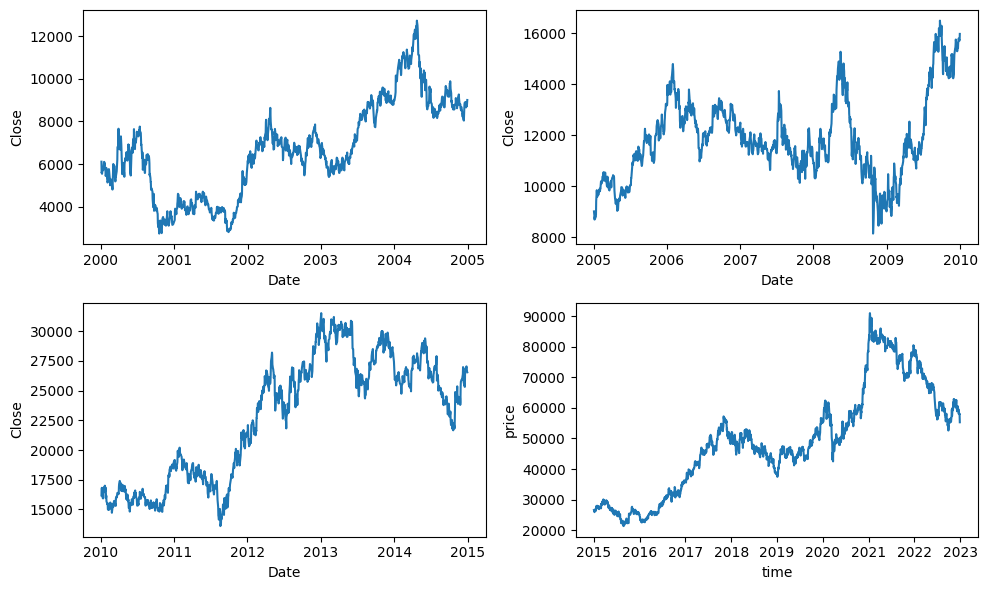

In [9]:
time_step = [['2000', '2005'], ['2005', '2010'], ['2010', '2015'], ['2015', '2023']]
fig, axes = plt.subplots(2,2)
fig.set_size_inches(10,6)
for i in range(4):  # 2행 2열이니까 4번 돌기
  ax = axes[i // 2, i % 2]
  df = stock.loc[(stock.index > time_step[i][0]) & (stock.index < time_step[i][1])]
  sns.lineplot(y=df['Close'], x=df.index, ax=ax)
  plt.xlabel('time')
  plt.ylabel('price')
plt.tight_layout()
plt.show()


In [10]:
# 전처리
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(stock[scale_cols])
df = pd.DataFrame(df_scaled, columns=scale_cols)
print(df.head(3))

# train_test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=12, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)  # (4800, 4) (1200, 4) (4800,) (1200,)
print(x_train[:2])
print(y_train[:2])

       Open      High       Low     Close    Volume
0  0.039424  0.036777  0.038659  0.008950  0.005862
1  0.039756  0.038636  0.039777  0.010989  0.007469
2  0.042082  0.040072  0.041676  0.012688  0.008795
(4800, 4) (1200, 4) (4800,) (1200,)
       Open      High       Low    Volume
0  0.039424  0.036777  0.038659  0.005862
1  0.039756  0.038636  0.039777  0.007469
0    0.008950
1    0.010989
Name: Close, dtype: float64


In [11]:
# Dataset을 활용 sequence dataset 구성
import tensorflow as tf

def window_dataset_func(series, window_size, batch_size, shuffle):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)  # 예) (60000,28,28) -> (28*28)의 크기 6만개로 슬라이싱
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)  # Dataset.window(그룹화할 윈도우 크기, 이동 수)
  ds = ds.flat_map(lambda w:w.batch(window_size + 1))
  if shuffle:
    ds = ds.shuffle(buffer_size=1000)
  ds = ds.map(lambda w:(w[:-1], w[-1]))
  return ds.batch(batch_size).prefetch(1)  # dataset 1개(20일 단위 데이터)를 미리 준비해둠, prefetch : 훈련속도를 더 빠르게 처리
  #  ds.batch(batch_size) 큰 데이터는 메모리에 한번에 올릴 수 없으므로 batch_size 만큼 나누어 학습을 시킴

WINDOW_SIZE=20
BATCH_SIZE=32
print()
train_data = window_dataset_func(y_train, WINDOW_SIZE, BATCH_SIZE, True) # train data 섞기
test_data = window_dataset_func(y_train, WINDOW_SIZE, BATCH_SIZE, False)  # test데이터는 검증이 목적이기 때문에 섞으면 안됨!!!!!!!!!!!

print(train_data, test_data)

for data in train_data.take(1):
  print(data[0].shape) # (32, 20, 1) batch_size, window_size, feature
  print(data[1].shape) # (32, 1)     batch_size, feature



<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
(32, 20, 1)
(32, 1)


In [20]:
# 모델생성
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import Huber
from keras.optimizers import Adam

model = Sequential([
    Conv1D(filters=32, kernel_size=5, padding='causal', activation='relu', input_shape=[WINDOW_SIZE, 1]),  # 시간 순서를 위반하지 않는 시계열 데이터 처리시 효과
    LSTM(16, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(1)
])

print(model.summary())

loss = Huber()
optimizer=Adam(learning_rate=0.0005)
model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

es = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_data, epochs=150, batch_size=32, validation_data=test_data, verbose=2, callbacks=[es])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 20, 32)            192       
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3617 (14.13 KB)
Trainable params: 3617 (14.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/150
150/150 - 7s - loss: 1.3223e-04 - mse: 2.6447e-04 - val_loss: 4.8208e-05 - val_mse: 9.6417e-05 - 7s/epoch - 48ms/step
Epoch 2/150
150/1

150/150 [==============================] - 3s 17ms/step
예측값 :  [0.02432466 0.02300577 0.02251859 0.02354552 0.02439299 0.02379826
 0.02302578 0.02135459 0.01952499 0.01839518]
실제 값 :  [0.48453608 0.49473207 0.49189985 0.49416563 0.4924663  0.47660587
 0.47887164 0.49076696 0.4924663  0.50719384]


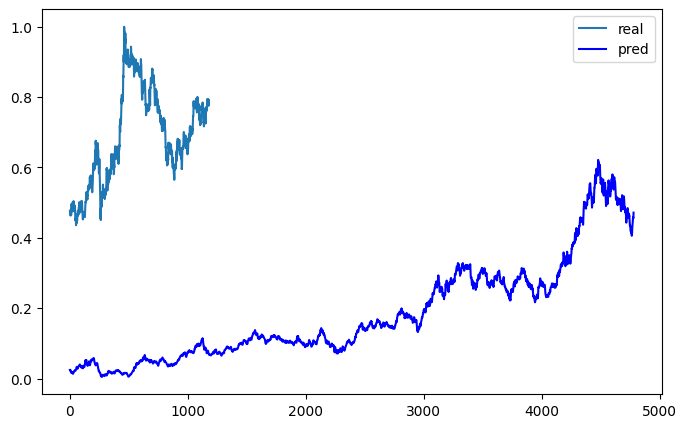

In [19]:
import numpy as np

pred = model.predict(test_data)
print('예측값 : ', pred[:10].flatten())
print('실제 값 : ', np.asarray(y_test)[:10])

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(np.asarray(y_test)[20:], label='real')
plt.plot(pred, label='pred', c='blue')
plt.legend()
plt.show()